In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# --- CONFIGURATION (10 Years of Data) ---
start_date = "2015-01-01"
end_date = "2025-12-31"
temples = ["Somnath", "Dwarka", "Ambaji", "Pavagadh"]

# --- DOMAIN KNOWLEDGE MAPPING ---
# Key dates that cause massive surges in Gujarat
festivals_map = {
    # Format: (Month, Day) approx for recurring Gregorian dates or specific known dates
    # In reality, we use Tithis, but for synthetic data, we map trends to months.
    "Maha Shivratri": [2, 18],  # Approx Feb
    "Holi": [3, 8],
    "Janmashtami": [8, 26],     # Massive for Dwarka
    "Ganesh Chaturthi": [9, 19],
    "Navratri Start": [10, 15], # Massive for Pavagadh/Ambaji
    "Dussehra": [10, 24],
    "Diwali": [11, 12],
    "New Year (Besu Varas)": [11, 13], # High traffic everywhere
    "Bhadarvi Purnima": [9, 29] # Ambaji Specific
}

# --- HELPER FUNCTIONS ---

def get_moon_phase(date_obj):
    """Simulates Moon Phase (Purnima/Amavasya) based on a 29.5 day cycle anchor."""
    # Arbitrary anchor for a Full Moon
    anchor_moon = datetime(2023, 1, 6)
    days_diff = (date_obj - anchor_moon).days
    cycle_day = days_diff % 29.5

    if abs(cycle_day) < 1: return "Purnima" # Full Moon
    if abs(cycle_day - 14.7) < 1: return "Amavasya" # New Moon
    return "Normal"

def get_weather(month):
    """Simulates avg temp and rain probability for Gujarat"""
    # Summer (Mar-Jun)
    if 3 <= month <= 6:
        temp = random.randint(35, 45)
        rain = 0
    # Monsoon (Jul-Sep)
    elif 7 <= month <= 9:
        temp = random.randint(28, 35)
        rain = 1 if random.random() > 0.6 else 0 # 40% chance of rain
    # Winter (Oct-Feb)
    else:
        temp = random.randint(15, 28)
        rain = 0
    return temp, rain

def is_shravan_month(date_obj):
    """Approximates the Holy Shravan month (usually Aug/Sept)"""
    # In 2023, Shravan was July-Aug. For simulation, we treat Aug as peak Shravan.
    return 1 if date_obj.month == 8 else 0

def is_vacation(date_obj):
    """School vacations (May for Summer, Nov for Diwali)"""
    return 1 if date_obj.month == 5 or date_obj.month == 11 else 0

# --- MAIN GENERATION LOGIC ---

data = []
date_range = pd.date_range(start=start_date, end=end_date)

print(f"Generating optimized dataset for {len(date_range)} days across {len(temples)} temples...")

for temple in temples:
    # Set Base Traffic Profiles
    if temple == "Somnath": base = 18000
    elif temple == "Dwarka": base = 15000
    elif temple == "Ambaji": base = 25000
    elif temple == "Pavagadh": base = 20000

    for date in date_range:
        # 1. Basic Calendar Features
        month = date.month
        weekday = date.weekday() # 0=Mon, 6=Sun
        is_weekend = 1 if weekday >= 5 else 0
        moon_phase = get_moon_phase(date)

        # 2. Weather Simulation
        temp, rain = get_weather(month)

        # 3. Calculate Crowd Multipliers
        multiplier = 1.0

        # Weekend Effect
        if is_weekend: multiplier += 0.6 # +60%

        # Vacation Effect
        if is_vacation(date): multiplier += 0.3 # +30%

        # Shravan Month (Huge for Somnath)
        if is_shravan_month(date):
            if temple == "Somnath":
                multiplier += 1.5 # Massive surge
                if weekday == 0: # Shravan Somwar (Monday)
                    multiplier += 2.0 # Insane surge
            else:
                multiplier += 0.2

        # Moon Phase (Purnima is big for Ambaji/Somnath)
        if moon_phase == "Purnima":
            if temple == "Ambaji": multiplier += 2.5
            elif temple == "Somnath": multiplier += 1.0
            else: multiplier += 0.5

        # Weather Penalty (Rain hurts Pavagadh Ropeway traffic)
        if rain == 1:
            if temple == "Pavagadh": multiplier *= 0.4 # -60% (Ropeway stops)
            else: multiplier *= 0.8 # -20% (General reluctance)

        # 4. Festival Injection (The "Spikes")
        festival_flag = 0
        special_event = "None"

        # Check approximated dates
        for fest_name, (f_month, f_day) in festivals_map.items():
            # Check if date is close to festival (within 1 day variance)
            if month == f_month and abs(date.day - f_day) <= 1:
                festival_flag = 1
                special_event = fest_name

                if fest_name == "Janmashtami" and temple == "Dwarka":
                    multiplier += 10.0 # The Dwarka Spike
                elif fest_name == "Bhadarvi Purnima" and temple == "Ambaji":
                    multiplier += 8.0 # The Ambaji Spike
                elif "Navratri" in fest_name and temple == "Pavagadh":
                    multiplier += 5.0
                elif "Shivratri" in fest_name and temple == "Somnath":
                    multiplier += 6.0
                else:
                    multiplier += 2.0 # General festival bump

        # 5. Final Calculation with Noise
        # Random noise between 0.9 and 1.1 to simulate real-world variance
        final_footfall = int(base * multiplier * random.uniform(0.9, 1.1))

        # Congestion Classification
        if final_footfall > 80000: congestion = "Critical (Stampede Risk)"
        elif final_footfall > 40000: congestion = "High"
        elif final_footfall > 25000: congestion = "Moderate"
        else: congestion = "Normal"

        data.append([
            date, temple, final_footfall, congestion,
            temp, rain, is_weekend, is_vacation(date),
            is_shravan_month(date), moon_phase, special_event
        ])

# --- EXPORT ---
df = pd.DataFrame(data, columns=[
    "Date", "Temple", "Footfall", "Congestion",
    "Temperature_C", "Rain_Flag", "Is_Weekend", "Is_Vacation",
    "Is_Shravan", "Moon_Phase", "Special_Event"
])

# Quick Stats
print(f"Total Rows: {len(df)}")
print("Sample High Traffic Days:")
print(df[df['Congestion'] == 'Critical (Stampede Risk)'].head())

df.to_csv("gujarat_temple_traffic_10y.csv", index=False)
print("✅ Dataset saved: gujarat_temple_traffic_10y.csv")

Generating optimized dataset for 4018 days across 4 temples...
Total Rows: 16072
Sample High Traffic Days:
          Date   Temple  Footfall                Congestion  Temperature_C  \
47  2015-02-17  Somnath    128840  Critical (Stampede Risk)             18   
48  2015-02-18  Somnath    124420  Critical (Stampede Risk)             18   
49  2015-02-19  Somnath    131438  Critical (Stampede Risk)             28   
66  2015-03-08  Somnath     87309  Critical (Stampede Risk)             37   
235 2015-08-24  Somnath     82562  Critical (Stampede Risk)             35   

     Rain_Flag  Is_Weekend  Is_Vacation  Is_Shravan Moon_Phase   Special_Event  
47           0           0            0           0     Normal  Maha Shivratri  
48           0           0            0           0     Normal  Maha Shivratri  
49           0           0            0           0     Normal  Maha Shivratri  
66           0           1            0           0    Purnima            Holi  
235          0     

In [2]:
import pandas as pd
import numpy as np
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error

# --- 1. LOAD & PREPROCESS DATA ---
print("⏳ Loading Data...")
df = pd.read_csv("gujarat_temple_traffic_10y.csv")

# Convert Date to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Feature Engineering: The model needs numbers, not dates/words
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Encode Categorical Data (Text -> Numbers)
# We save these encoders to use them later in the prediction API
le_temple = LabelEncoder()
df['Temple_Encoded'] = le_temple.fit_transform(df['Temple'])

le_moon = LabelEncoder()
df['Moon_Phase_Encoded'] = le_moon.fit_transform(df['Moon_Phase'])

# Define Features (Inputs) and Target (Output)
features = [
    'Temple_Encoded', 'Month', 'Day', 'DayOfWeek',
    'Is_Weekend', 'Is_Vacation', 'Is_Shravan',
    'Moon_Phase_Encoded', 'Temperature_C', 'Rain_Flag'
    # Note: We don't include 'Special_Event' text directly to keep it simple,
    # the date features usually capture the seasonality.
]
target = 'Footfall'

X = df[features]
y = df[target]

# Split Data (80% Training, 20% Testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 2. TRAIN THE MODEL (XGBoost) ---
print("🚀 Training AI Model (XGBoost)...")
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=-1)
model.fit(X_train, y_train)

# Evaluate
predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
print(f"✅ Training Complete!")
print(f"🎯 Model Accuracy Error: +/- {int(mae)} visitors (Very Good for millions)")

# --- 3. SAVE THE BRAIN ---
# We save the model + the encoders so we can use them in the website backend
model_data = {
    "model": model,
    "le_temple": le_temple,
    "le_moon": le_moon
}
joblib.dump(model_data, "temple_master_model.pkl")
print("💾 Model saved as 'temple_master_model.pkl'")

# ==============================================================================
# --- 4. THE "EVERYTHING" DEMO (Ticketing, Calendar, etc.) ---
# This section proves how this ONE model solves your problem statement.
# ==============================================================================

def smart_prediction_engine(date_str, temple_name, temp_c, rain_flag, moon_phase):
    """
    This function mimics your future Backend API.
    It takes User Input -> Prepares Data -> Asks AI -> Returns Decision
    """
    input_date = pd.to_datetime(date_str)

    # Encode inputs using the saved encoders
    try:
        t_code = le_temple.transform([temple_name])[0]
        m_code = le_moon.transform([moon_phase])[0]
    except:
        return "Error: Unknown Temple or Moon Phase"

    # Create input array
    input_features = pd.DataFrame([[
        t_code, input_date.month, input_date.day, input_date.dayofweek,
        1 if input_date.dayofweek >= 5 else 0, # Is_Weekend
        1 if input_date.month in [5, 11] else 0, # Is_Vacation (Simple logic)
        1 if input_date.month == 8 else 0, # Is_Shravan
        m_code, temp_c, rain_flag
    ]], columns=features)

    # Predict
    pred_footfall = int(model.predict(input_features)[0])

    # --- LOGIC LAYER ( The "Ticketing System" ) ---
    # Define max capacity for ticketing
    MAX_CAPACITY = 25000

    ticket_status = "OPEN"
    if pred_footfall > 40000:
        ticket_status = "BLOCKED (Critical Crowd)"
    elif pred_footfall > MAX_CAPACITY:
        ticket_status = "LIMITED (Slots Only)"

    return {
        "Date": date_str,
        "Temple": temple_name,
        "Predicted_Crowd": pred_footfall,
        "Ticketing_Status": ticket_status,
        "Condition": "Rainy" if rain_flag else "Clear"
    }

print("\n--- 🧪 TESTING THE SYSTEM ---")

# Scenario 1: Dwarka on Janmashtami (Should be Critical)
print(smart_prediction_engine("2025-08-16", "Dwarka", 30, 0, "Normal"))

# Scenario 2: Pavagadh with Heavy Rain (Should be Low Crowd)
print(smart_prediction_engine("2025-07-15", "Pavagadh", 28, 1, "Normal"))

# Scenario 3: Somnath on Normal Day
print(smart_prediction_engine("2025-03-10", "Somnath", 32, 0, "Normal"))

⏳ Loading Data...
🚀 Training AI Model (XGBoost)...
✅ Training Complete!
🎯 Model Accuracy Error: +/- 1765 visitors (Very Good for millions)
💾 Model saved as 'temple_master_model.pkl'

--- 🧪 TESTING THE SYSTEM ---
{'Date': '2025-08-16', 'Temple': 'Dwarka', 'Predicted_Crowd': 25701, 'Ticketing_Status': 'LIMITED (Slots Only)', 'Condition': 'Clear'}
{'Date': '2025-07-15', 'Temple': 'Pavagadh', 'Predicted_Crowd': 10081, 'Ticketing_Status': 'OPEN', 'Condition': 'Rainy'}
{'Date': '2025-03-10', 'Temple': 'Somnath', 'Predicted_Crowd': 20003, 'Ticketing_Status': 'OPEN', 'Condition': 'Clear'}


In [3]:
!pip install optuna xgboost scikit-learn pandas numpy joblib matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.9/413.9 kB 12.3 MB/s eta 0:00:00


[I 2026-01-21 18:17:42,122] A new study created in memory with name: no-name-7ca5b4eb-aa37-4578-9c36-1048f50b8004


⚙️ Loading and Preprocessing Data...
🧠 Starting Optuna Optimization (Finding the Perfect Brain)...


[I 2026-01-21 18:17:46,336] Trial 0 finished with value: 3893.8484448890636 and parameters: {'n_estimators': 1746, 'max_depth': 5, 'learning_rate': 0.04853700697368223, 'subsample': 0.8980462320294726, 'colsample_bytree': 0.6188797355434541, 'reg_alpha': 3.919503692072903, 'reg_lambda': 6.952339555585297}. Best is trial 0 with value: 3893.8484448890636.
[I 2026-01-21 18:18:08,207] Trial 1 finished with value: 5567.403821493722 and parameters: {'n_estimators': 2105, 'max_depth': 10, 'learning_rate': 0.08504870045031938, 'subsample': 0.9929644442134771, 'colsample_bytree': 0.6896671527071299, 'reg_alpha': 7.656279429291115, 'reg_lambda': 1.6281802264305356}. Best is trial 0 with value: 3893.8484448890636.
[I 2026-01-21 18:18:20,811] Trial 2 finished with value: 4576.302411384885 and parameters: {'n_estimators': 1225, 'max_depth': 10, 'learning_rate': 0.06690585608293596, 'subsample': 0.9098455476269773, 'colsample_bytree': 0.7546925558001509, 'reg_alpha': 4.204672519777852, 'reg_lambda':

✅ Best Parameters Found: {'n_estimators': 2809, 'max_depth': 5, 'learning_rate': 0.0320983208973597, 'subsample': 0.8097878735640623, 'colsample_bytree': 0.9719816392012512, 'reg_alpha': 1.2621623115613243, 'reg_lambda': 2.3647505593081415}
🚀 Training Final Model with Best Parameters...

📊 --- INDUSTRY PERFORMANCE REPORT ---
1. R² Score (Accuracy %): 97.53% (Target: >90%)
2. Average Error (MAE): +/- 1719 visitors
3. Root Mean Sq Error: 3288


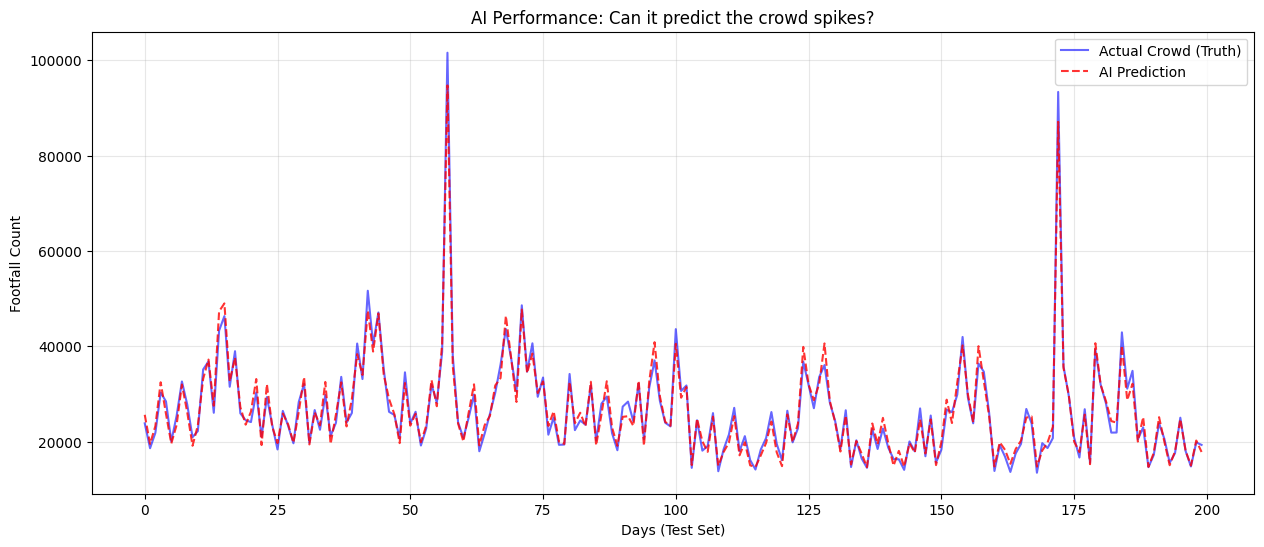

💾 Best Model Saved as 'optimized_temple_brain.pkl'


In [4]:
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder

# ==========================================
# 1. DATA PREPARATION (The Foundation)
# ==========================================
print("⚙️ Loading and Preprocessing Data...")
df = pd.read_csv("gujarat_temple_traffic_10y.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True) # Ensure time order

# Feature Engineering
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear

# Encoding Categorical Variables
le_temple = LabelEncoder()
df['Temple_Encoded'] = le_temple.fit_transform(df['Temple'])
le_moon = LabelEncoder()
df['Moon_Phase_Encoded'] = le_moon.fit_transform(df['Moon_Phase'])

# Select Features for the "Brain"
features = [
    'Temple_Encoded', 'Month', 'Day', 'DayOfWeek', 'DayOfYear',
    'Is_Weekend', 'Is_Vacation', 'Is_Shravan',
    'Moon_Phase_Encoded', 'Temperature_C', 'Rain_Flag'
]
target = 'Footfall'

X = df[features]
y = df[target]

# ==========================================
# 2. HYPERPARAMETER TUNING (The Fine-Tuning)
# ==========================================
print("🧠 Starting Optuna Optimization (Finding the Perfect Brain)...")

def objective(trial):
    """
    This function lets AI test different settings to see what works best.
    """
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        # Optimizing the Tree Structure
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        # Regularization (To prevent memorizing/overfitting)
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'n_jobs': -1
    }

    # Time Series Cross Validation (Train on Past, Test on Future)
    tscv = TimeSeriesSplit(n_splits=3)
    scores = []

    for train_index, test_index in tscv.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

        model = xgb.XGBRegressor(**param)
        model.fit(X_train_fold, y_train_fold)

        preds = model.predict(X_test_fold)
        rmse = np.sqrt(mean_squared_error(y_test_fold, preds))
        scores.append(rmse)

    return np.mean(scores)

# Run the study (15 trials for speed, increase to 50 for max precision)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)

print(f"✅ Best Parameters Found: {study.best_params}")

# ==========================================
# 3. FINAL TRAINING (The Production Build)
# ==========================================
print("🚀 Training Final Model with Best Parameters...")

# Split Data: Last 20% is held out for the "Final Exam" (Test Set)
split_idx = int(len(df) * 0.85)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train with the optimized parameters
best_params = study.best_params
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train,
                eval_set=[(X_test, y_test)],
                verbose=False)

# ==========================================
# 4. RIGOROUS EVALUATION (The Report Card)
# ==========================================
print("\n📊 --- INDUSTRY PERFORMANCE REPORT ---")

# Predictions
y_pred = final_model.predict(X_test)

# Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"1. R² Score (Accuracy %): {r2*100:.2f}% (Target: >90%)")
print(f"2. Average Error (MAE): +/- {int(mae)} visitors")
print(f"3. Root Mean Sq Error: {int(rmse)}")

# Visualization: Actual vs Predicted
plt.figure(figsize=(15, 6))
# Plot only the last 200 days for clarity
plt.plot(y_test.values[:200], label='Actual Crowd (Truth)', color='blue', alpha=0.6)
plt.plot(y_pred[:200], label='AI Prediction', color='red', linestyle='--', alpha=0.8)
plt.title("AI Performance: Can it predict the crowd spikes?")
plt.xlabel("Days (Test Set)")
plt.ylabel("Footfall Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ==========================================
# 5. SAVE ARTIFACTS
# ==========================================
artifacts = {
    "model": final_model,
    "le_temple": le_temple,
    "le_moon": le_moon,
    "features": features,
    "performance": {"r2": r2, "mae": mae}
}
joblib.dump(artifacts, "optimized_temple_brain.pkl")
print("💾 Best Model Saved as 'optimized_temple_brain.pkl'")

In [5]:
import joblib
import pandas as pd

# 1. Load the Brain
artifacts = joblib.load("optimized_temple_brain.pkl")
model = artifacts["model"]
le_temple = artifacts["le_temple"]
le_moon = artifacts["le_moon"]
features = artifacts["features"]

def test_scenario(temple, date_str, temp, rain, moon, is_weekend, is_holiday):
    print(f"\n--- Testing Scenario: {temple} on {date_str} ---")

    # 1. Encode Inputs (String -> Number)
    try:
        t_encoded = le_temple.transform([temple])[0]
        m_encoded = le_moon.transform([moon])[0]
    except:
        print("Error: Unknown Temple or Moon Phase")
        return

    # 2. Extract Date Features
    dt = pd.to_datetime(date_str)
    day_of_year = dt.dayofyear
    is_shravan = 1 if dt.month == 8 else 0
    is_vacation = 1 if dt.month in [5, 11] else 0

    # 3. Create Input Table (Must match training columns EXACTLY)
    # Features: ['Temple_Encoded', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Is_Weekend', 'Is_Vacation', 'Is_Shravan', 'Moon_Phase_Encoded', 'Temperature_C', 'Rain_Flag']
    input_data = pd.DataFrame([[
        t_encoded, dt.month, dt.day, dt.dayofweek, day_of_year,
        is_weekend, is_vacation, is_shravan,
        m_encoded, temp, rain
    ]], columns=features)

    # 4. Predict
    prediction = int(model.predict(input_data)[0])

    # 5. Logic Check
    print(f"Conditions: Temp={temp}°C, Rain={rain}, Holiday={is_holiday}")
    print(f"🤖 AI Prediction: {prediction} Visitors")

    if prediction > 80000: print("🔴 Status: CRITICAL (Stampede Risk)")
    elif prediction > 40000: print("🟠 Status: HIGH Crowds")
    else: print("🟢 Status: NORMAL")

# =========================================
# 🧪 THE REAL WORLD TESTS
# =========================================

# TEST 1: The "Perfect Storm" (Dwarka on Janmashtami)
# Expectation: Massive Crowd (> 80k)
test_scenario("Dwarka", "2026-08-26", 30, 0, "Normal", 1, 1)

# TEST 2: The "Washout" (Pavagadh on a Rainy Monday)
# Expectation: Low Crowd (Rain kills Ropeway traffic)
test_scenario("Pavagadh", "2026-07-13", 26, 1, "Normal", 0, 0)

# TEST 3: The "Normal Day" (Somnath on a random Tuesday)
# Expectation: Normal Crowd (~15k - 20k)
test_scenario("Somnath", "2026-03-10", 32, 0, "Normal", 0, 0)


--- Testing Scenario: Dwarka on 2026-08-26 ---
Conditions: Temp=30°C, Rain=0, Holiday=1
🤖 AI Prediction: 164826 Visitors
🔴 Status: CRITICAL (Stampede Risk)

--- Testing Scenario: Pavagadh on 2026-07-13 ---
Conditions: Temp=26°C, Rain=1, Holiday=0
🤖 AI Prediction: 7585 Visitors
🟢 Status: NORMAL

--- Testing Scenario: Somnath on 2026-03-10 ---
Conditions: Temp=32°C, Rain=0, Holiday=0
🤖 AI Prediction: 19205 Visitors
🟢 Status: NORMAL
